In [ ]:
#!kaggle competitions download -c tabular-playground-series-apr-2021

tabular-playground-series-apr-2021.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
#!apt-get install unzip

In [ ]:
#!unzip tabular-playground-series-apr-2021.zip

In [ ]:
import pandas as pd
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")
df_sample = pd.read_csv("sample_submission.csv")

In [ ]:
df_test['Survived'] = 0

In [ ]:
from pandas.api.types import is_string_dtype, is_numeric_dtype, is_categorical_dtype
from fastai.tabular.all import *
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from dtreeviz.trees import *
from IPython.display import Image, display_svg, SVG

pd.options.display.max_rows = 20
pd.options.display.max_columns = 12
from sklearn.metrics import accuracy_score

In [ ]:
df_test

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Survived
0,100000,3,"Holliday, Daniel",male,19.0,0,0,24745,63.01,NaN,S,0
1,100001,3,"Nguyen, Lorraine",female,53.0,0,0,13264,5.81,NaN,S,0
2,100002,1,"Harris, Heather",female,19.0,0,0,25990,38.91,B15315,C,0
3,100003,2,"Larsen, Eric",male,25.0,0,0,314011,12.93,NaN,S,0
4,100004,1,"Cleary, Sarah",female,17.0,0,2,26203,26.89,B22515,C,0
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,199995,3,"Cash, Cheryle",female,27.0,0,0,7686,10.12,NaN,Q,0
99996,199996,1,"Brown, Howard",male,59.0,1,0,13004,68.31,NaN,S,0
99997,199997,3,"Lightfoot, Cameron",male,47.0,0,0,4383317,10.87,NaN,S,0
99998,199998,1,"Jacobsen, Margaret",female,49.0,1,2,PC 26988,29.68,B20828,C,0


In [ ]:
procs = [Categorify, FillMissing]

In [ ]:
to_drop = ['Name','PassengerId','Cabin','Ticket']
df_train = df_train.drop(to_drop,axis=1)
df_test = df_test.drop(to_drop,axis=1)

In [ ]:
cont,cat = cont_cat_split(df_train, dep_var='Survived')

In [ ]:
f = TrainTestSplitter(test_size=0.2, random_state=42)
prep_train = TabularPandas(df_train, procs, cat, cont, y_names='Survived',splits=f(df_test))

In [ ]:
prep_test = TabularPandas(df_test, procs, cat, cont)

In [ ]:
xs,y = prep_train.train.xs,prep_train.train.y
valid_xs,valid_y = prep_train.valid.xs,prep_train.valid.y

m = DecisionTreeClassifier(max_leaf_nodes=4)
m.fit(xs, y);

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


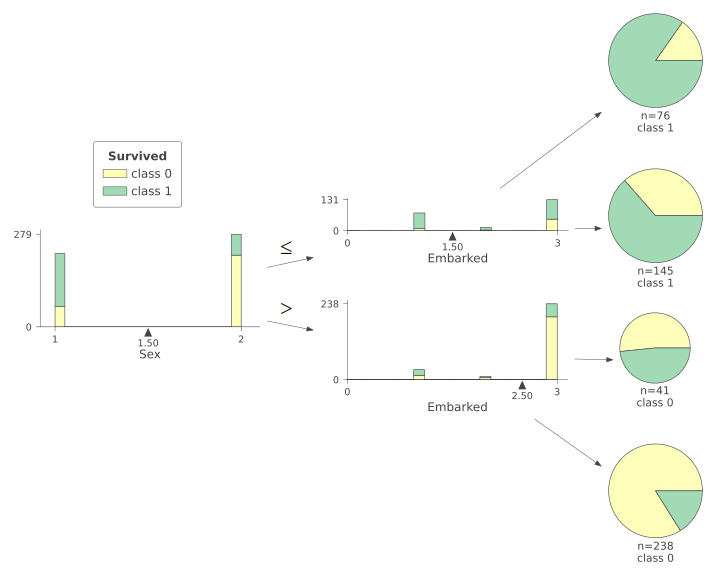

In [ ]:
samp_idx = np.random.permutation(len(y))[:500]
dtreeviz(m, xs.iloc[samp_idx], y.iloc[samp_idx], xs.columns, 'Survived',
        fontname='DejaVu Sans', scale=1.6, label_fontsize=10,
        orientation='LR')

In [ ]:
m = DecisionTreeClassifier()
m.fit(xs, y);

In [ ]:
accuracy_score(m.predict(xs).reshape(-1,1),y)

0.9940625

In [ ]:
accuracy_score(m.predict(valid_xs).reshape(-1,1),valid_y)

0.6849

In [ ]:
m.get_n_leaves(), len(xs)

(22832, 80000)

In [ ]:
m = RandomForestClassifier(n_estimators=40,
       max_features=0.5, min_samples_leaf=5).fit(xs,y)

In [ ]:
accuracy_score(m.predict(xs).reshape(-1,1),y)

0.8264125

In [ ]:
accuracy_score(m.predict(valid_xs).reshape(-1,1),valid_y)

0.7662

In [ ]:
def rf_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

In [ ]:
fi = rf_feat_importance(m, xs)
fi[:10]

,cols,imp
1,Sex,0.408698
8,Fare,0.234067
4,Embarked,0.121359
7,Age,0.111842
0,Pclass,0.079107
3,Parch,0.022508
2,SibSp,0.020167
5,Age_na,0.002186
6,Fare_na,0.000066


In [ ]:
procs_nn = [Categorify, FillMissing, Normalize]
nn_prep_train = TabularPandas(df_train, procs_nn, cat, cont, y_names='Survived',splits=f(df_train))
nn_prep_test = TabularPandas(df_test, procs_nn, cat, cont,splits=None)

In [ ]:
dls = nn_prep_train.dataloaders(1024)

In [ ]:
learn = tabular_learner(dls, layers=[500,250],
                        n_out=1)

In [ ]:
learn.fit_one_cycle(10, 1e-2)

epoch,train_loss,valid_loss,time
0,0.178195,0.168784,00:02
1,0.170793,0.174908,00:02
2,0.166896,0.165432,00:01
3,0.163490,0.163626,00:01
4,0.161755,0.161586,00:01
5,0.160870,0.161872,00:02
6,0.160215,0.160465,00:01
7,0.159016,0.159907,00:02
8,0.158496,0.159535,00:01
9,0.157783,0.159443,00:02


In [ ]:
dl = learn.dls.test_dl(df_test)

In [ ]:
probs, _ = learn.get_preds(dl=dl)

In [ ]:
preds = torch.round(probs)
preds = preds.tolist()
preds = [int(i[0]) for i in preds]

In [ ]:
df_sample['Survived'] = preds

In [ ]:
df_sample.set_index('PassengerId', inplace=True)

In [ ]:
df_sample

,Survived
PassengerId,
100000,0
100001,1
100002,1
100003,0
100004,1
...,...
199995,1
199996,0
199997,0


In [ ]:
df_sample.to_csv('predictions.csv')

In [ ]:
!kaggle competitions submit tabular-playground-series-apr-2021 -f predictions.csv -m "let's see how it goes"

Traceback (most recent call last):
  File "/opt/conda/envs/fastai/bin/kaggle", line 5, in <module>
    from kaggle.cli import main
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/kaggle/__init__.py", line 23, in <module>
    api.authenticate()
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 169, in authenticate
    self._load_config(config_data)
  File "/opt/conda/envs/fastai/lib/python3.8/site-packages/kaggle/api/kaggle_api_extended.py", line 210, in _load_config
    raise ValueError('Error: Missing %s in configuration.' % item)
ValueError: Error: Missing username in configuration.
